In [1]:
import time
import os
import glob
import cv2
import numpy as np

from keras.utils import np_utils
from keras.utils import to_categorical

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


<h1>Dataset</h1>

In [2]:
### paths to training and testing data
train_path = 'data/train'
test_path = 'data/validation'

### other parameters
classes = ["dog", "cat"]
num_classes = len(classes)

### image dimensions
img_width, img_height = 224, 224

In [3]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
    return resized

In [4]:
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Loading training images...')
    folders = ["dogs", "cats"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

In [5]:
def load_test():
    X_test = []
    X_test_id = []
    y_test = []
    start_time = time.time()

    print('Loading testing images...')
    folders = ["dogs", "cats"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(test_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_test.append(img)
            X_test_id.append(flbase)
            y_test.append(index)

    print('testing data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, y_test, X_test_id

In [6]:
def normalize_train_data():
    train_data, train_target, train_id = load_train()

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    train_data = train_data.astype('float32')
    train_data = train_data / 255
    train_target = to_categorical(train_target, num_classes)

    print('Shape of training data:', train_data.shape)
    return train_data, train_target, train_id

In [7]:
def normalize_test_data():
    test_data, test_target, test_id = load_test()

    test_data = np.array(test_data, dtype=np.uint8)
    test_target = np.array(test_target, dtype=np.uint8)

    test_data = test_data.astype('float32')
    test_data = test_data / 255
    test_target = to_categorical(test_target, num_classes)

    print('Shape of testing data:', test_data.shape)
    return test_data, test_target, test_id

In [8]:
x_train, y_train, train_id = normalize_train_data()

Loading training images...
Loading dogs files (Index: 0)
Loading cats files (Index: 1)
Training data load time: 14.42 seconds
Shape of training data: (6000, 224, 224, 3)


In [9]:
x_test, y_test, test_id = normalize_test_data()

Loading testing images...
Loading dogs files (Index: 0)
Loading cats files (Index: 1)
testing data load time: 2.08 seconds
Shape of testing data: (1000, 224, 224, 3)


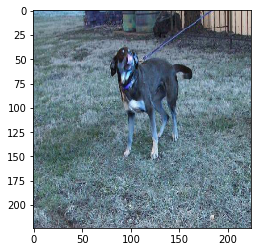

In [10]:
plt.imshow(x_train[0])

<h2>Criando uma CNN</h2>

In [11]:
from keras.layers import *
from keras.models import Model
from keras import optimizers

In [12]:
input_node = Input(shape=(img_width, img_height, 3))

conv_1 = Conv2D(filters=4, kernel_size=(3, 3), strides=1,
                activation='relu')(input_node)
pool_1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(filters=8, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(filters=16, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_2)
conv_4 = Conv2D(filters=32, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_3)

flat = Flatten()(conv_4)

fc1 = Dense(num_classes, activation='softmax')(flat)

model = Model(input_node, fc1)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        4640      
__________

<h2>Compilando o modelo</h2>

In [14]:
from keras.optimizers import *
from keras.metrics import *

In [15]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(min_delta=1e-3, monitor='val_loss', patience=3)

In [17]:
model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=1,
          callbacks=[early_stop],
          validation_data=(x_test, y_test))

Train on 6000 samples, validate on 1000 samples
Epoch 1/1
6000/6000 [==============================] - 152s 25ms/step - loss: 0.7230 - acc: 0.5710 - val_loss: 0.6518 - val_acc: 0.6250


<h2>MobileNet v2</h2>

In [6]:
"""MobileNet v2 models for Keras.

# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""

from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, add, Reshape
from keras.applications.mobilenet import relu6, DepthwiseConv2D

from keras import backend as K

In [7]:
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.

    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)

In [8]:
def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.

    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = add([x, inputs])
    return x

In [9]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.

    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x

In [10]:
def MobileNetv2(input_shape, k):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.

    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
    # Returns
        MobileNetv2 model.
    """

    inputs = Input(shape=input_shape)
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)

    x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)

    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)

    model = Model(inputs, output)

    return model

<h2>Train the MobileNet v2 model</h2>

In [13]:
"""
Train the MobileNet V2 model
"""
import os
import sys
import argparse
import pandas as pd

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Reshape, Activation
from keras.models import Model

In [14]:
def generate(batch, size):
    """Data generation and augmentation

    # Arguments
        batch: Integer, batch size.
        size: Integer, image size.

    # Returns
        train_generator: train set generator
        validation_generator: validation set generator
        count1: Integer, number of train set.
        count2: Integer, number of test set.
    """

    #  Using the data Augmentation in traning data
    ptrain = 'data/train'
    pval = 'data/validation'

    datagen1 = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

    datagen2 = ImageDataGenerator(rescale=1. / 255)

    train_generator = datagen1.flow_from_directory(
        ptrain,
        target_size=(size, size),
        batch_size=batch,
        class_mode='categorical')

    validation_generator = datagen2.flow_from_directory(
        pval,
        target_size=(size, size),
        batch_size=batch,
        class_mode='categorical')

    count1 = 0
    for root, dirs, files in os.walk(ptrain):
        for each in files:
            count1 += 1

    count2 = 0
    for root, dirs, files in os.walk(pval):
        for each in files:
            count2 += 1

    return train_generator, validation_generator, count1, count2

In [15]:
def fine_tune(num_classes, weights, model):
    """Re-build model with current num_classes.

    # Arguments
        num_classes, Integer, The number of classes of dataset.
        tune, String, The pre_trained model weights.
        model, Model, The model structure.
    """
    model.load_weights(weights)

    x = model.get_layer('Dropout').output
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((num_classes,))(x)

    model = Model(inputs=model.input, outputs=output)

    return model

In [16]:
def train(batch, epochs, num_classes, size, weights, tclasses):
    """Train the model.

    # Arguments
        batch: Integer, The number of train samples per batch.
        epochs: Integer, The number of train iterations.
        num_classes, Integer, The number of classes of dataset.
        size: Integer, image size.
        weights, String, The pre_trained model weights.
        tclasses, Integer, The number of classes of pre-trained model.
    """

    train_generator, validation_generator, count1, count2 = generate(batch, size)
    
    if weights:
        model = MobileNetv2((size, size, 3), tclasses)
        model = fine_tune(num_classes, weights, model)
    else:
        model = MobileNetv2((size, size, 3), num_classes)
        
    opt = Adam()
    earlystop = EarlyStopping(monitor='val_acc', patience=3, verbose=0, mode='auto')
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    hist = model.fit_generator(
        train_generator,
        validation_data=validation_generator,
        steps_per_epoch=count1 // batch,
        validation_steps=count2 // batch,
        epochs=epochs,
        callbacks=[earlystop])

    if not os.path.exists('model'):
        os.makedirs('model')

    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/hist.csv', encoding='utf-8', index=False)
    model.save_weights('model/weights.h5')

In [19]:
 """Train the model.
    # Arguments
        batch: Integer, The number of train samples per batch.
        epochs: Integer, The number of train iterations.
        num_classes, Integer, The number of classes of dataset.
        size: Integer, image size.
        weights, String, The pre_trained model weights.
        tclasses, Integer, The number of classes of pre-trained model.
    """
    
batch = 32
epochs = 10
num_classes = 2
size = 224
weights = False
tclasses = 0

train(batch, epochs, num_classes, size, weights, tclasses)

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
187/187 [==============================] - 4408s 24s/step - loss: 0.7384 - acc: 0.5770 - val_loss: 0.8827 - val_acc: 0.5060
Epoch 2/10
187/187 [==============================] - 4369s 23s/step - loss: 0.6435 - acc: 0.6303 - val_loss: 1.0940 - val_acc: 0.5383
Epoch 3/10
187/187 [==============================] - 4370s 23s/step - loss: 0.6264 - acc: 0.6532 - val_loss: 0.8705 - val_acc: 0.6139
Epoch 4/10
187/187 [==============================] - 4367s 23s/step - loss: 0.6010 - acc: 0.6728 - val_loss: 0.6596 - val_acc: 0.6200
Epoch 5/10
187/187 [==============================] - 4301s 23s/step - loss: 0.5896 - acc: 0.6808 - val_loss: 0.7491 - val_acc: 0.6018
Epoch 6/10
187/187 [==============================] - 4294s 23s/step - loss: 0.5933 - acc: 0.6873 - val_loss: 0.9482 - val_acc: 0.5685
Epoch 7/10
187/187 [==============================] - 4291s 23s/step - loss: 0.5785 - acc: 0.6990 - val_lo